In [1]:
# Basic lib imports
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from scipy import stats
%matplotlib inline

/data/chamal/projects/nikhil/code/python/conda/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Data imports
baseline_dir = '/data/chamal/projects/nikhil/data/trajectory_prediction/'
adnimerge_file = 'ADNIMERGE.csv'
hc_vol_file = 'adni2-qcvols_nodups.csv'
CT_file = 'CT/ADNI2_subject_ROI_CT_dict_AAL.csv'
hc_data = pd.read_csv(baseline_dir + hc_vol_file)
ct_data = pd.read_csv(baseline_dir + CT_file)
#print ct_data.columns

In [53]:
#HC + CT Merge
in_data = pd.merge(hc_data, ct_data, on='ImageUID',how='inner')
#in_data.to_csv(baseline_dir + 'adni2-qcvols_nodups_aal_ct.csv'

0       2.449090
1       2.504522
2       2.124152
3       1.972491
4       2.235790
5       2.291010
6       2.275279
7       2.238324
8       2.182247
9       1.964647
10      2.681607
11      2.686093
12      2.671424
13      2.513368
14      2.381751
15      2.323800
16      2.240890
17      2.530787
18      2.506782
19      2.437663
20      2.071766
21      2.741530
22      1.809617
23      2.581623
24      2.573184
25      2.648044
26      2.617432
27      2.431300
28      1.938519
29      2.528653
          ...   
3162    2.419476
3163    2.662114
3164    2.611063
3165    2.644934
3166    2.539076
3167    2.591109
3168    2.315362
3169    2.507160
3170    2.434054
3171    2.412478
3172    2.328818
3173    2.348437
3174    2.353137
3175    2.392337
3176    2.347662
3177    1.308317
3178    1.427033
3179    2.386256
3180    2.370757
3181    2.368639
3182    2.329697
3183    2.243143
3184    2.219945
3185    2.173614
3186    2.203268
3187    2.313279
3188    2.407434
3189    2.3752

In [64]:
# Extract subset of columns and subjects (cohort)
cohort = 'ADNI2'
#demographics
col_list_demo = ['PTID','AGE','PTGENDER','APOE4']
data_demo  = in_data[(in_data.ORIGPROT == cohort) & (in_data.HPC_QC!=0) & (in_data.VISCODE == 'bl')][col_list_demo]

#add a column with numerical DX mapping
# set(['MCI to NL', 'Dementia', 'NL', 'MCI'])
# set(['Dementia', 'NL', 'NL to MCI', 'MCI', 'MCI to Dementia', 'MCI to NL'])
# set(['Dementia', 'NL', 'NL to MCI', 'MCI', 'MCI to Dementia', 'MCI to NL'])
# set([nan, 'Dementia', 'NL', 'NL to MCI', 'MCI', 'Dementia to MCI', 'MCI to Dementia', 'MCI to NL'])
in_data['DX_cat'] = in_data['DX'].replace(['MCI to NL', 'NL'], 0)
in_data['DX_cat'] = in_data['DX_cat'].replace(['NL to MCI', 'MCI', 'Dementia to MCI'], 1)
in_data['DX_cat'] = in_data['DX_cat'].replace(['NL to Dementia','MCI to Dementia', 'Dementia'], 2)
in_data['DX_cat'].values.astype(float)

# features / variables
clinical_feat = ['PTID','DX','DX_cat','ADAS13','MMSE']
hc_feat = ['L_CA1','L_subiculum','L_CA4DG','L_CA2CA3','L_stratum','L_Alv','L_Fimb','L_Fornix','L_Mam',
                 'R_CA1','R_subiculum','R_CA4DG','R_CA2CA3','R_stratum','R_Alv','R_Fimb','R_Fornix','R_Mam']
ct_feat = ['AAL_1', 'AAL_2', 'AAL_3','AAL_4', 'AAL_5', 'AAL_6', 'AAL_7', 'AAL_8', 'AAL_9', 'AAL_10',
                 'AAL_11', 'AAL_12', 'AAL_13', 'AAL_14', 'AAL_15', 'AAL_16', 'AAL_17', 'AAL_18', 'AAL_19', 'AAL_20', 
                 'AAL_21', 'AAL_22', 'AAL_23', 'AAL_24', 'AAL_25', 'AAL_26', 'AAL_27', 'AAL_28', 'AAL_29', 'AAL_30', 
                 'AAL_31', 'AAL_32', 'AAL_33', 'AAL_34', 'AAL_35', 'AAL_36', 'AAL_39', 'AAL_40', 'AAL_43', 'AAL_44', 
                 'AAL_45', 'AAL_46', 'AAL_47', 'AAL_48', 'AAL_49', 'AAL_50', 'AAL_51', 'AAL_52', 'AAL_53', 'AAL_54',
                 'AAL_55', 'AAL_56', 'AAL_57', 'AAL_58', 'AAL_59', 'AAL_60', 'AAL_61', 'AAL_62', 'AAL_63', 'AAL_64', 
                 'AAL_65', 'AAL_66', 'AAL_67', 'AAL_68', 'AAL_69', 'AAL_70', 'AAL_79', 'AAL_80', 'AAL_81', 'AAL_82',
                 'AAL_83', 'AAL_84', 'AAL_85', 'AAL_86', 'AAL_87', 'AAL_88', 'AAL_89', 'AAL_90']

col_list_feat = clinical_feat + hc_feat + ct_feat

data_bl  = in_data[(in_data.ORIGPROT == cohort) & (in_data.HPC_QC!=0) & (in_data.VISCODE == 'bl')][col_list_feat]
#data_bl = data_bl.drop_duplicates(subset='PTID', keep='first')
data_m03 = in_data[(in_data.ORIGPROT == cohort) & (in_data.HPC_QC!=0) & (in_data.VISCODE == 'm03')][col_list_feat]
#data_m03 = data_m03.drop_duplicates(subset='PTID', keep='first')
data_m06 = in_data[(in_data.ORIGPROT == cohort) & (in_data.HPC_QC!=0) & (in_data.VISCODE == 'm06')][col_list_feat]
#data_m06 = data_m06.drop_duplicates(subset='PTID', keep='first')
data_m12 = in_data[(in_data.ORIGPROT == cohort) & (in_data.HPC_QC!=0) & (in_data.VISCODE == 'm12')][col_list_feat]
#data_m12 = data_m12.drop_duplicates(subset='PTID', keep='first')
data_m24 = in_data[(in_data.ORIGPROT == cohort) & (in_data.HPC_QC!=0) & (in_data.VISCODE == 'm24')][col_list_feat]
#data_m24 = data_m24.drop_duplicates(subset='PTID', keep='first')
data_m36 = in_data[(in_data.ORIGPROT == cohort) & (in_data.HPC_QC!=0) & (in_data.VISCODE == 'm36')][col_list_feat]
data_m48 = in_data[(in_data.ORIGPROT == cohort) & (in_data.HPC_QC!=0) & (in_data.VISCODE == 'm48')][col_list_feat]

print 'number of subjects: {}'.format([len(data_demo.PTID.values), len(data_bl.PTID.values),len(data_m03.PTID.values),
                                       len(data_m06.PTID.values),len(data_m12.PTID.values),len(data_m24.PTID.values)])

number of subjects: [654, 654, 547, 482, 485, 337]


In [65]:
# number of HC subjects: [698, 698, 588, 520, 522, 371]
# number of CT subjects: [654, 654, 547, 482, 485, 337]
# number of HC_CT subjects: [654, 654, 547, 482, 485, 337]

#Rename Columns and Merge into 1 table 

bl=[]
m03=[]
m06=[]
m12=[]
m24=[]

for col in col_list_feat:
    if col == 'PTID':
        bl.append('PTID')
        m03.append('PTID')
        m06.append('PTID')
        m12.append('PTID')
        m24.append('PTID')
    else:
        bl.append(col+'_bl')
        m03.append(col+'_m03')
        m06.append(col+'_m06')
        m12.append(col+'_m12')
        m24.append(col+'_m24')
            
data_bl.columns= bl
data_m03.columns=m03
data_m06.columns=m06
data_m12.columns=m12
data_m24.columns=m24
        
test_merge = pd.merge(data_demo, data_bl, on='PTID',how='inner')
print len(test_merge)
test_merge = pd.merge(test_merge, data_m03, on='PTID',how='inner')
print len(test_merge)
test_merge = pd.merge(test_merge, data_m06, on='PTID',how='inner')
print len(test_merge)
test_merge = pd.merge(test_merge, data_m12, on='PTID',how='inner')
print len(test_merge)
test_merge = pd.merge(test_merge, data_m24, on='PTID',how='inner')
print len(test_merge)

test_merge=test_merge.drop_duplicates(subset='PTID', keep='first')
print len(test_merge)

#add score diffs 
time_points = ['_m03','_m06','_m12','_m24']
for col in col_list_feat:
    for tp in time_points:
        if not col in ['PTID','DX']:
            test_merge['{}{}_diff'.format(col,tp)] = test_merge['{}{}'.format(col,tp)] - test_merge['{}_bl'.format(col)]



654
531
434
398
269
269


In [10]:
dups = [item for item, count in collections.Counter(data_m12.PTID).items() if count > 1]
print dups
print len(dups)

[]
0


In [ ]:
# plotting stats
plt.rcParams['figure.figsize'] = (15, 20)
font_small = 8
font_med = 16
font_large = 24
# pick variable(s) i.e. columns and rows with no NaN values 
clinical_var = col_list_feat
time_points = ['_m06','_m12','_m24']
subplot_idx = 0
for row, c_var in enumerate(clinical_var):
    if not c_var in ['PTID','DX']:
        for col, time_point in enumerate(time_points):
            subplot_idx += 1
            plt.subplot(len(clinical_var), len(time_points), subplot_idx)
            x = test_merge[c_var + time_point] - test_merge[c_var + '_bl']
            print 'total number of subjects: {}'.format(len(x.values))
            x = x[np.isfinite(x)]
            print 'total number of subjects without NaNs: {}'.format(len(x.values))
            sns.distplot(x, kde=False, rug=True)
            plt.xlabel('{} - score_bl'.format(c_var + time_point), fontsize=font_med)
            title_str = 'N={}, mean: {:3.2f}, std: {:3.2f}'.format(len(x.values), np.mean(x),np.std(x))
            plt.title(title_str)

In [ ]:
# Draw a stratified Cognititive decline plot per Dx
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
clinical_var = col_list_feat
time_points = ['_m06','_m12','_m24']
i=0
for c_var in clinical_var:
    if not c_var in ['PTID','DX','DX_cat']:
        for tp in time_points:
            i+=1
            col = c_var + tp + '_diff'
            #plt.subplot(2,3,i)
            g = sns.factorplot(x="DX_cat_bl", y=col, data=test_merge, size=6, kind="bar", palette="muted")
            #g.despine(left=True)
            g.set_ylabels(col, fontsize = font_large)

            print 'population mean: {}, std: {}'.format(np.mean(test_merge[col]),np.std(test_merge[col]))

In [ ]:
clinical_var = ['ADAS13','MMSE','DX_cat']
for i, c_var in enumerate(clinical_var):
    traj = [test_merge[c_var + '_bl'], test_merge[c_var + '_m06'], 
            test_merge[c_var + '_m12'], test_merge[c_var + '_m24']]
    traj = np.array(traj)
    t = test_merge['AGE']
    t = np.vstack((t,t+0.5,t+1,t+2))
    plt.subplot(3,1,i+1)
    for j in np.arange(t.shape[1]):        
        plt.plot(t[:,j],traj[:,j],'.-')
    plt.xlabel('AGE')
    plt.ylabel(c_var)
    
    

In [ ]:
clinical_var = ['MMSE','ADAS13']
time_points = ['_bl','_m03','_m06','_m12','_m24']
feat = []
for i, c_var in enumerate(clinical_var):
    for tp in time_points:
        feat.append(test_merge[c_var + tp].values - test_merge[c_var + '_bl'].values)

    
feat.append(test_merge['AGE'].values)
feat.append(test_merge['APOE4'].values)
sex = test_merge['PTGENDER'].values == 'Female'
feat.append(sex)

feat = np.transpose(np.array(feat))
print feat.shape
feat = feat[~np.isnan(feat).any(axis=1)]
print feat.shape
feat_X = feat[:,:feat.shape[1]-3]
print feat_X.shape

In [ ]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
embeddings = model.fit_transform(feat_X) 

In [ ]:
plt.rcParams['figure.figsize'] = (15, 10)
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

Sex = feat[:,-1]
APOE4 = feat[:,-2]
Age = feat[:,-3]
Age = Age<np.median(Age)

df = pd.DataFrame({'tsne_x':embeddings[:,0],'tsne_y':embeddings[:,1], 'Sex':Sex,'APOE4':APOE4,'Age':Age})

sns.lmplot('tsne_x', 'tsne_y', 
           data=df, 
           fit_reg=False,            
           hue="Age",  
           scatter_kws={"marker": "D", "s": 25})

plt.title('{} clusters wrt demographics'.format(clinical_var))

sns.lmplot('tsne_x', 'tsne_y', 
           data=df, 
           fit_reg=False,            
           hue="APOE4",
           scatter_kws={"marker": "D", "s": 25})

sns.lmplot('tsne_x', 'tsne_y', 
           data=df, 
           fit_reg=False,            
           hue="Sex",
           scatter_kws={"marker": "D", "s": 25})


In [ ]:
clinical_var = ['MMSE','ADAS13']
time_points = ['_m06','_m12','_m24']

for c_var in clinical_var:
    for tp in time_points:
        g = sns.PairGrid(test_merge, y_vars=c_var + tp + "_diff",
                         x_vars=["AGE_median_split","PTGENDER", "APOE4", 'DX_cat_bl'],
                         size=5, aspect=.5)

        # Draw a seaborn pointplot onto each Axes
        g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])    
        if c_var =='MMSE':
            g.set(ylim=(-6, 0.5))            
        else:
            g.set(ylim=(-4, 14))
        sns.despine(fig=g.fig, left=True)
        

In [ ]:
sns.lmplot('MMSE_m06_diff', 'L_CA1_m06_diff', 
           data=test_merge, 
           fit_reg=True,            
           scatter_kws={"marker": "D", "s": 50})

sns.lmplot('MMSE_m12_diff', 'L_CA1_m12_diff', 
           data=test_merge, 
           fit_reg=True,            
           scatter_kws={"marker": "D", "s": 50})

sns.lmplot('MMSE_m24_diff', 'L_CA1_m24_diff', 
           data=test_merge, 
           fit_reg=True,            
           scatter_kws={"marker": "D", "s": 50})

In [ ]:
# Compute the correlation matrix


# # Select a subset of the networks
# used_networks = [1, 5, 6, 7, 8, 11, 12, 13, 16, 17]
# used_columns = (df.columns.get_level_values("network")
#                           .astype(int)
#                           .isin(used_networks))
# df = df.loc[:, used_columns]

df= test_merge[['AGE', 'APOE4', 'DX_cat_m06_diff', 'DX_cat_m12_diff', 'DX_cat_m24_diff', 
               'ADAS13_m06_diff', 'ADAS13_m12_diff', 'ADAS13_m24_diff', 'MMSE_m06_diff', 'MMSE_m12_diff', 'MMSE_m24_diff', 
               'L_CA1_m06_diff', 'L_CA1_m12_diff', 'L_CA1_m24_diff', 'L_subiculum_m06_diff', 'L_subiculum_m12_diff', 'L_subiculum_m24_diff', 
               'L_CA4DG_m06_diff', 'L_CA4DG_m12_diff', 'L_CA4DG_m24_diff', 'L_CA2CA3_m06_diff', 'L_CA2CA3_m12_diff', 'L_CA2CA3_m24_diff', 
               'L_stratum_m06_diff', 'L_stratum_m12_diff',
               'L_stratum_m24_diff', 'L_Alv_m06_diff', 'L_Alv_m12_diff', 'L_Alv_m24_diff', 'L_Fimb_m06_diff', 'L_Fimb_m12_diff', 'L_Fimb_m24_diff',
               'L_Fornix_m06_diff', 'L_Fornix_m12_diff', 'L_Fornix_m24_diff', 'L_Mam_m06_diff', 'L_Mam_m12_diff', 'L_Mam_m24_diff', 'R_CA1_m06_diff', 
               'R_CA1_m12_diff', 'R_CA1_m24_diff', 'R_subiculum_m06_diff', 'R_subiculum_m12_diff', 'R_subiculum_m24_diff', 'R_CA4DG_m06_diff', 
               'R_CA4DG_m12_diff', 'R_CA4DG_m24_diff', 'R_CA2CA3_m06_diff', 'R_CA2CA3_m12_diff', 'R_CA2CA3_m24_diff', 'R_stratum_m06_diff', 
               'R_stratum_m12_diff', 'R_stratum_m24_diff', 'R_Alv_m06_diff', 'R_Alv_m12_diff', 'R_Alv_m24_diff', 'R_Fimb_m06_diff', 'R_Fimb_m12_diff', 
               'R_Fimb_m24_diff', 'R_Fornix_m06_diff', 'R_Fornix_m12_diff', 'R_Fornix_m24_diff', 'R_Mam_m06_diff', 'R_Mam_m12_diff', 'R_Mam_m24_diff']]

# Create a custom colormap for the heatmap values
cmap = sns.diverging_palette(h_neg=210, h_pos=350, s=90, l=30, as_cmap=True)

# Draw the full plot
cg = sns.clustermap(df.corr(), linewidths=.5, figsize=(13, 13), cmap=cmap)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

In [88]:
x = test_merge

feat_list = ct_feat #pick one: hc_feat or ct_feat
                
time_points = ['_bl','_m06','_m12','_m24']
corr_dict = {}
idx = 0
feat_grp_size = 9 #Esthetics - number of lines in the same plot. 
for f, feat in enumerate(feat_list):
    for tp in time_points:
        adas = test_merge['ADAS13'+tp].values
        adas_clean = adas[np.isfinite(adas)]        
        y = test_merge[feat+tp].values
        y = y[np.isfinite(adas)]
        adas_r = stats.pearsonr(y,adas_clean)[0]
        
        mmse = test_merge['MMSE'+tp].values
        mmse_clean = mmse[np.isfinite(mmse)]        
        y = test_merge[feat+tp].values
        y = y[np.isfinite(mmse)]
        mmse_r = stats.pearsonr(y,mmse_clean)[0]
        
        corr_dict[idx]={'structure':feat,'time-point':tp,'adas_r':adas_r,'mmse_r':mmse_r,'feat_grp':f/feat_grp_size}
        idx += 1
    
df = pd.DataFrame.from_dict(corr_dict,orient='index')
    

In [89]:
len(feat_list)

78

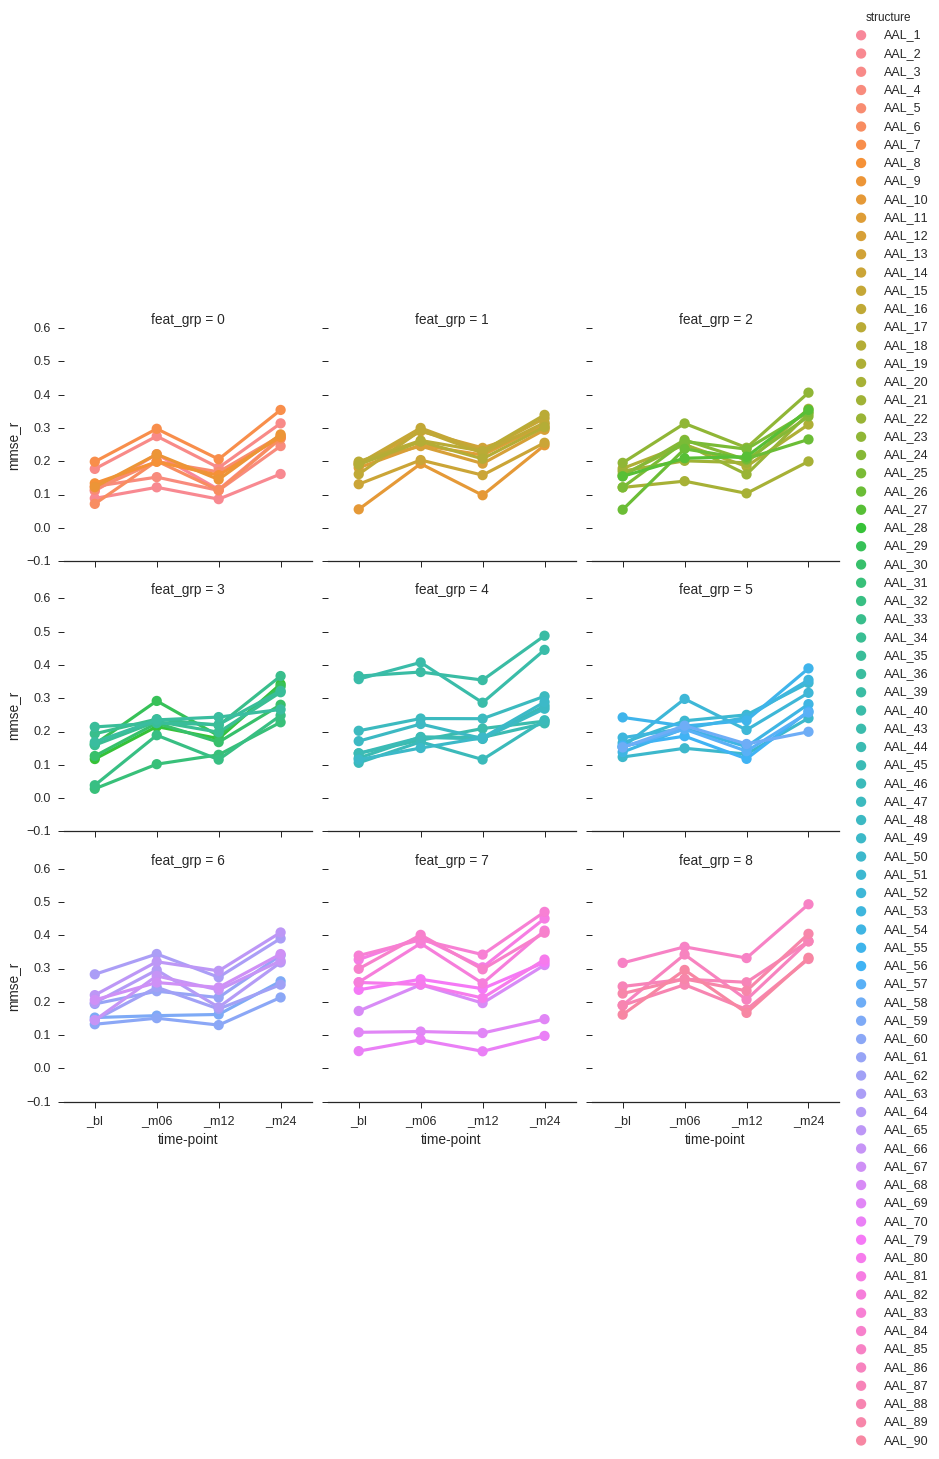

In [90]:
sns.set_context("notebook", font_scale=1.25)
sns.set_style("ticks")

if len(feat_list) == 18: #hc_feat
    g = sns.factorplot(x="time-point", y='mmse_r', hue='structure', col='feat_grp', col_wrap=2,
                       markers=['o', 'd', 's','+', '^', '>', 'v', '<','x','o', 'd', 's','+', '^', '>', 'v', '<','x'],
                       data=df, size=5)
else: 
    g = sns.factorplot(x="time-point", y='mmse_r', hue='structure', col='feat_grp', col_wrap=3, data=df, size=4)
g.despine(left=True)
#plt.title('Correlation between structural measure vs. clinical scores')
